# Achieving Fine Grained Control Over Incidence of False-positives and False-negatives in NLP Classification Tasks using Methods Inspired by Game Theory

## Akshay Channesh

Main Reference: Parikh, Prashant. 2019. _Communication and content_. (Topics at the Grammar-Discourse Interface 4). Berlin: Language Science Press. DOI: 10.5281/zenodo.3243924


# Classifier

First we open the SMS Spam Collection v.1 dataset. The corpus has been collected by [Tiago Agostinho de Almeida](http://www.dt.fee.unicamp.br/~tiago) and [José María Gómez Hidalgo](http://www.esp.uem.es/jmgomez), and can be found [here.](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection#)

We need a simple classifier example to illustrate our algorithm. We've chosen the tutorial by KDnuggets titled _Spam Filter in Python: Naive Bayes from Scratch_ for our example. This can be found [here.](https://www.kdnuggets.com/2020/07/spam-filter-python-naive-bayes-scratch.html)

In [83]:
import pandas as pd

sms_spam = pd.read_csv('SMSSpamCollection', sep='\t', header = None, names = ["Label", "SMS"])

print(f"The dataset has {sms_spam.shape[0]} rows and {sms_spam.shape[1]} columns.")
sms_spam.head()

The dataset has 5572 rows and 2 columns.


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [84]:
sms_spam['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

We find that the dataset has about $86.6\%$ of ham texts and $13.4\%$ of spam texts.

## Data Set Preparation

We only use $3\%$ of the data for training. This is because the task is very simple and training it with any larger data will result in very little errors made. Since we are more interested in the errors, we'd like to keep the accuracy around $95\%$ to begin with.

Now we randomize the data and prepare the dataset.

In [85]:
# Set the % of data to be used for training
training_set_size_percentage = 3 / 100

# Randomize the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * training_set_size_percentage)

# Split into training and test sets
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set     = data_randomized[training_test_index:].reset_index(drop=True)

# Make a copy of the dataset for later tests
test_set_untouched = test_set.copy()

After this we find the dataset has been split in this manner.

In [86]:
print(f"We have {training_set.shape[0]} for training and {test_set.shape[0]} rows for testing.")

We have 167 for training and 5405 rows for testing.


## Data cleaning

We remove all the punctuation and make everything lowercase.

In [87]:
training_set['SMS'] = training_set['SMS'].str.replace(
   '\W', ' ', regex=True) # Removes punctuation
training_set['SMS'] = training_set['SMS'].str.lower()

Now the dataset looks like this.

In [88]:
training_set.head(3)

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired


## Creating the vocabulary

We make a set of all unique words in our data. The `set` data structure removes all duplicates.

In [89]:
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)

vocabulary = list(set(vocabulary))

print(f"The vocabulary size is {len(vocabulary)}.")

The vocabulary size is 1012.


### Counting the word occurances in each row

We can now count the words occuring in each of the rows.

In [90]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

word_counts = pd.DataFrame(word_counts_per_sms)

The `word_counts` data frame is now prepared and looks like this.

In [91]:
word_counts.head()

,and,ham,so,means,bored,won,fri,anything,der,course,...,cookies,offer,w111wx,3,little,done,haven,place,money,4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We concat this `word_count` frame with the `training_set` to get our final cleaned set of data.

In [92]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Label,SMS,and,ham,so,means,bored,won,fri,anything,...,cookies,offer,w111wx,3,little,done,haven,place,money,4
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We use Laplace smoothing with $\alpha$ = 1

In [93]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages  = training_set_clean[training_set_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham  = len(ham_messages)  / len(training_set_clean)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

### Calculating the Parameters

In [94]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum() # spam_messages already defined
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam

    n_word_given_ham = ham_messages[word].sum() # ham_messages already defined
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

### The Naive Classifier Function

In [95]:
import re

def classify(message):
    '''
    message: a string
    '''

    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham: 
            p_ham_given_message *= parameters_ham[word]
    
    p_h = p_ham_given_message / (p_spam_given_message + p_ham_given_message)
    p_s = p_spam_given_message / (p_spam_given_message + p_ham_given_message)
    
    # Return the probabilites of being spam and ham 
    return p_s, p_h  

## Testing the classifier

In [96]:
def classify_test_set(message):
    
    p_spam_given_message, p_ham_given_message = classify(message)
    
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [97]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,"My Parents, My Kidz, My Friends n My Colleague...",ham
1,ham,"Yeah go on then, bored and depressed sittin wa...",ham
2,ham,Can you plz tell me the ans. BSLVYL sent via f...,ham
3,ham,Lol yes. Our friendship is hanging on a thread...,ham
4,ham,cool. We will have fun practicing making babies!,ham


### Calculating Accuracy

In [98]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 5170
Incorrect: 235
Accuracy: 0.9565217391304348


Now we calculate the number of false positives and false negatives.

In [99]:
f_pos = 0
f_neg = 0

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == "ham" and row['predicted'] == "spam":
        f_pos += 1
    if row['Label'] == "spam" and row['predicted'] == "ham":
        f_neg += 1

print('False positives: (when a true ham is falsly flagged as spam)', f_pos)  
print('False negatives: (when a true Spam is falsly allowed as ham)', f_neg)

False positives: (when a true ham is falsly flagged as spam) 27
False negatives: (when a true Spam is falsly allowed as ham) 207


# FGC-Classify
Now we investigate the same classification when we run it through FGC-Classify algorithm. We try and reduce the false negatives by setting the utilities appropriately.

![Image: Classification Game](./images/game.png)

In [100]:
# Make a copy of the original test set
test_set2 = test_set_untouched.copy()

In [101]:
def fgc_classify_test_set(message, utility):
    
    p_s, p_h = classify(message)
    
    # Utilities are (HS, HH, SS, SH) tuple
    payoff = utility[0] * p_s, utility[1] * p_h, utility[2] * p_s, utility[3] * p_h
        
    if max(payoff) == payoff[0] or max(payoff) == payoff[2]:
        return 'spam'
    elif max(payoff) == payoff[1] or max(payoff) == payoff[3]:
        return 'ham'
    else:
        return 'needs human classification'

## Testing the FGC-Classifier

In [102]:
print(fgc_classify_test_set('WINNER!! This is the secret code to unlock the money: C3421.', (1,1,1,1)))

ham


### New Test Set

In [103]:
test_util = (1,10,10,2)

def fgc(msg):
    return fgc_classify_test_set(msg, test_util)

test_set2['predicted'] = test_set2['SMS'].apply(fgc)
test_set2.head()

,Label,SMS,predicted
0,ham,"My Parents, My Kidz, My Friends n My Colleague...",ham
1,ham,"Yeah go on then, bored and depressed sittin wa...",ham
2,ham,Can you plz tell me the ans. BSLVYL sent via f...,ham
3,ham,Lol yes. Our friendship is hanging on a thread...,ham
4,ham,cool. We will have fun practicing making babies!,ham


In [104]:
correct = 0
total = test_set2.shape[0]

for row in test_set2.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

f_pos = 0
f_neg = 0

for row in test_set2.iterrows():
    row = row[1]
    if row['Label'] == "ham" and row['predicted'] == "spam":
        f_pos += 1
    if row['Label'] == "spam" and row['predicted'] == "ham":
        f_neg += 1

print('False positives: (when a true ham is falsly flagged as spam)', f_pos)  
print('False negatives: (when a true Spam is falsly allowed as ham)', f_neg)


Correct: 5170
Incorrect: 235
Accuracy: 0.9565217391304348
False positives: (when a true ham is falsly flagged as spam) 27
False negatives: (when a true Spam is falsly allowed as ham) 207


# Reducing False Positives

In [105]:
def run_fgc_for_util(util):
    # Make a copy of the original test set
    test_set_u = test_set_untouched.copy()
    
    def fgc(msg):
        return fgc_classify_test_set(msg, util)

    test_set_u['predicted'] = test_set_u['SMS'].apply(fgc)
    test_set_u.head()
    
    correct = 0
    total = test_set_u.shape[0]
    f_pos = 0
    f_neg = 0

    for row in test_set_u.iterrows():
        row = row[1]
        if row['Label'] == row['predicted']:
            correct += 1
        if row['Label'] == "ham" and row['predicted'] == "spam":
            f_pos += 1
        if row['Label'] == "spam" and row['predicted'] == "ham":
            f_neg += 1

    return correct, total - correct, correct/total, f_pos, f_neg
    print('Correct:', correct)
    print('Incorrect:', total - correct)
    print('Accuracy:', correct/total)
    print('False positives: (when a true ham is falsly flagged as spam)', f_pos)  
    print('False negatives: (when a true Spam is falsly allowed as ham)', f_neg)
    
    

## Reducing False positives by having more utility in S,H

In [106]:
print("Correct, Incorrect, Accuracy, F_Pos, F_Neg")
util_list = [(1,10,10,3) , (1,10,10,7), (1,10,10,10), (1,10,10,12), \
             (1,10,10,15), (1,10,10,17), (1,10,10,20), (1,10,10,30), \
             (1,10,10,50), (1,10,10,100), (1,10,10,200)]
output_list = list(map(run_fgc_for_util, util_list))

from pprint import pprint
pprint(output_list)



Correct, Incorrect, Accuracy, F_Pos, F_Neg
[(5170, 235, 0.9565217391304348, 27, 207),
 (5170, 235, 0.9565217391304348, 27, 207),
 (5170, 235, 0.9565217391304348, 27, 207),
 (5162, 243, 0.9550416281221091, 25, 217),
 (5161, 244, 0.9548566142460685, 17, 226),
 (5159, 246, 0.9544865864939871, 16, 229),
 (5153, 252, 0.9533765032377428, 12, 239),
 (5143, 262, 0.9515263644773359, 4, 257),
 (5126, 279, 0.9483811285846439, 3, 275),
 (5087, 318, 0.9411655874190564, 3, 314),
 (5068, 337, 0.937650323774283, 2, 334)]


[0.957, 0.957, 0.957, 0.955, 0.955, 0.954, 0.953, 0.952, 0.948, 0.941, 0.938] [27, 27, 27, 25, 17, 16, 12, 4, 3, 3, 2]


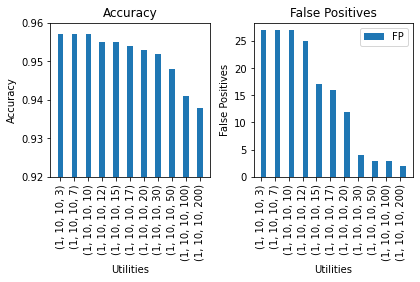

In [107]:

acc = []
pos = []
for i in output_list:
    acc.append(round(i[2], 3))
    pos.append(i[3])
print(acc, pos)


import numpy as np 
import matplotlib.pyplot as plt 
  
X = util_list
Ygirls = acc
Zboys = pos
  
X_axis = np.arange(len(X))

plt.subplot(1, 2, 1)
#plt.plot(X_axis, Ygirls, 'r', linewidth=5, linestyle=':')
plt.bar(X_axis , Ygirls, 0.4, label = 'Girls')
plt.title('Accuracy')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.ylim([0.92,0.96])

plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Utilities")
plt.ylabel("Accuracy")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
 
# g is gor green color
#plt.plot(X_axis, Zboys, 'g', linewidth=5)
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'FP')
plt.title('False Positives')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
 
# space between the plots
plt.tight_layout(pad=1)

#plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Girls')
#plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')
  
plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Utilities")
plt.ylabel("False Positives")
plt.title("False Positives")
plt.legend()
plt.show()

### Reducing false negatives by reducing H,H vs S,H

In [108]:
print("Correct, Incorrect, Accuracy, F_Pos, F_Neg")
util_list = [(1,10,50,10) , (1,10,60,10), (1,10,100,10), (1,10,200,10), \
             (1,10,400,10), (1,10,800,10)]
output_list = list(map(run_fgc_for_util, util_list))
pprint(output_list)

Correct, Incorrect, Accuracy, F_Pos, F_Neg
[(5167, 238, 0.9559666975023127, 84, 153),
 (5157, 248, 0.9541165587419056, 97, 150),
 (5058, 347, 0.9358001850138761, 217, 129),
 (4950, 455, 0.9158186864014801, 353, 101),
 (4769, 636, 0.8823311748381129, 549, 86),
 (4536, 869, 0.8392229417206291, 786, 82)]


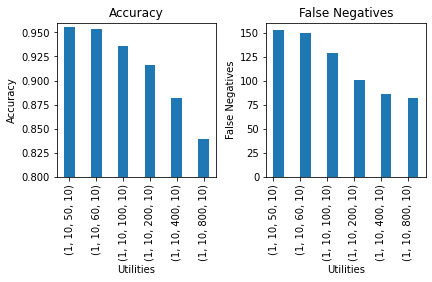

In [109]:

acc = []
pos = []
for i in output_list:
    acc.append(round(i[2], 3))
    pos.append(i[4])

X = util_list
Ygirls = acc
Zboys = pos
  
X_axis = np.arange(len(X))

plt.subplot(1, 2, 1)
#plt.plot(X_axis, Ygirls, 'r', linewidth=5, linestyle=':')
plt.bar(X_axis , Ygirls, 0.4, label = 'Girls')
plt.title('Accuracy')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.ylim([0.8, 0.96])

plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Utilities")
plt.ylabel("Accuracy")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
 
# g is gor green color
#plt.plot(X_axis, Zboys, 'g', linewidth=5)
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')
plt.title('False Negatives')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
 
# space between the plots
plt.tight_layout(pad=1)

#plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Girls')
#plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')
  
plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Utilities")
plt.ylabel("False Negatives")
plt.title("False Negatives")
#plt.legend()
plt.show()